# Example application of the extended Kalman filter to the noisy pendulum

ering and smoothing"

main.py
---

In [1]:

def pendulum(t, x, g, sigma_x1, sigma_y1, seed=None):

    if seed is not None:
        np.random.seed(seed)

    def f(x, t):
        x0 = x[0]
        x1 = x[1]

        rhs = np.asarray([x1, -g*np.sin(x0)])

        return rhs

    def h(x, t):
        return np.diag([0, sigma_x1])

    states = sdeint.itoint(f, h, x, t)
    x0 = states[:, 0]
    x1 = states[:, 1]

    data = np.zeros((t.size, 2))
    no_noise = np.zeros(t.size)
    data[:,0] = t[1]-t[0]
    data[:,1] = np.sin(x0) + np.random.randn(t.size) * np.sqrt(sigma_y1)
    no_noise[:] = np.sin(x0)
    return states, data, no_noise




# 2. Creating synthetic data <a name="synthetic"></a>



In [21]:
import numpy as np 
import matplotlib.pyplot as plt 
import scienceplots
import sdeint 
plt.style.use('science')

class NoisyPendulum:
    """ Simulates the signal from a noisy pendulum with process noise. 
    
    The observation is an arbitrary, non-linear combination of the states
    """
    
    def __init__(self,g,σp,σm, x, y,seed):
    
        self.g  = g
        self.σp = σp 
        self.σm = σm
        self.x0  = x
        self.y0  = y
        self.generator = np.random.default_rng(seed)
        
    def integrate(self,dt,n_steps):

        def f(x,t):
            x0 = x[0]
            x1 = x[1]

            rhs = np.array([x1, -self.g*np.sin(x0)])

            return rhs

        def h(x,t):
            return np.diag([0, self.σp])


        self.dt = dt
        self.n_steps      = n_steps
        self.t            = np.arange(0,self.n_steps*self.dt,self.dt)
        
        initial_conditions = np.array([self.x0,self.y0])

        states = sdeint.itoint(f, h, initial_conditions, self.t)
        self.x = states[:,0]
        self.y = states[:,1]

        #The observation, no noise
        self.observation_no_noise = np.sin(self.x)

        #add noise to the observation
        self.observation = self.observation_no_noise + self.generator.normal(0, self.σm,size=self.observation_no_noise.shape) 


        #Write all results to a single array
        
        self.results      = np.zeros((self.n_steps,4)) # 4 columns: x,y,observation_no_noise,observation 

        self.results[:,0] = self.x
        self.results[:,1] = self.y
        self.results[:,2] = self.observation_no_noise
        self.results[:,3] = self.observation

        return self.x,self.y,self.observation_no_noise,self.observation





    def plot_phase_space(self):
        """
        A plotting function which plots the evolution in the x-y phase plane
        """


        #Setup the figure
        h,w = 6,6
        rows = 1
        cols = 1
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)
    
        x = self.results[:,0]
        y = self.results[:,1]
        ax.plot(x,y)
        

        #Clean up axes
        fs=20
        ax.set_xlabel(r'$x_1$', fontsize=fs)
        ax.set_ylabel(r'$x_2$', fontsize=fs)
        ax.xaxis.set_tick_params(labelsize=fs-4)
        ax.yaxis.set_tick_params(labelsize=fs-4)


    def plot_timeseries(self,plot_true_state = False, prediction_data=None):
        """
        A plotting function which plots the states/observations as a function of time
        """


        #Setup the figure
        h,w =8,8
        rows = 3
        cols = 1
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)

    
        data_label = 'data'
        
        axes[0].plot(self.t,self.results[:,0],label=data_label) #x1
        axes[1].plot(self.t,self.results[:,1],label=data_label) #x2

        if plot_true_state:
            axes[2].scatter(self.t,self.results[:,3],label=data_label,marker='x') #actual noisy observations
            axes[2].plot(self.t,self.results[:,2],label='Truth',c='C1') #observation, no noise
        else:
            axes[2].plot(self.t,self.results[:,3],label=data_label) #actual noisy observations



        if prediction_data is not None:
            states = prediction_data[0]
            measurements = prediction_data[1]

            
            prediction_color = 'C2'
            prediction_label = 'prediction'
            axes[0].plot(self.t,states[:,0],c=prediction_color,label=prediction_label)
            axes[1].plot(self.t,states[:,1],c=prediction_color,label=prediction_label)
            
            axes[2].plot(self.t,measurements[:,0],c=prediction_color,label=prediction_label)

            plt.legend(fontsize=12)

        
    
        #Clean up axes
        fs=20
        axes[2].set_xlabel('t', fontsize=fs)

        axes[0].set_ylabel('x', fontsize=fs)
        axes[1].set_ylabel('y', fontsize=fs)
        axes[2].set_ylabel('z', fontsize=fs)

        plt.subplots_adjust(hspace=0.0)

        for ax in axes:
            ax.xaxis.set_tick_params(labelsize=fs-4)
            ax.yaxis.set_tick_params(labelsize=fs-4)

        # ax.legend(prop={'size':fs})



Lets take a quick look at the data

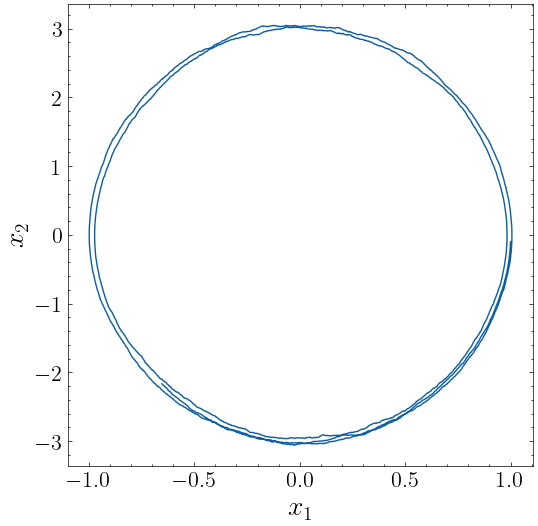

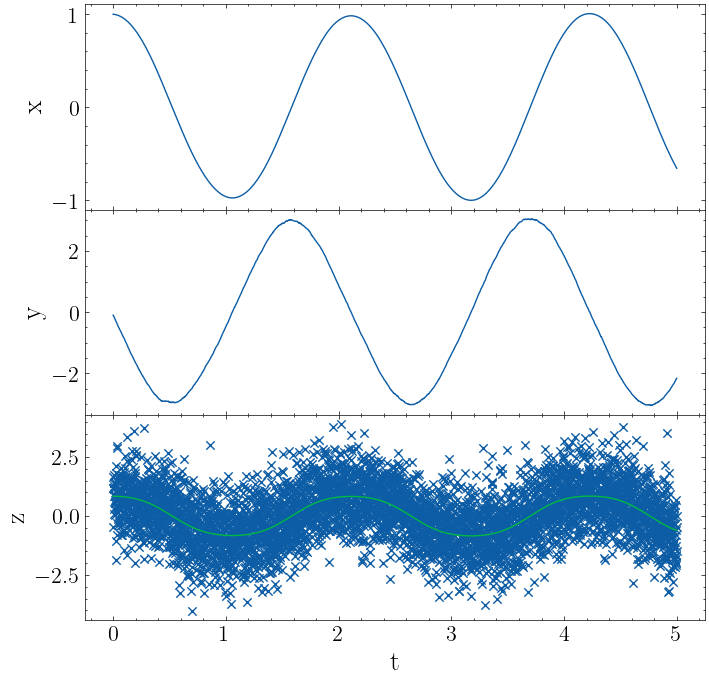

In [24]:
#Parameters of the system
g    = 10.0
σp   = 0.1
σm   = 1.0
x0   = 1.0
y0   = -0.1
seed = 1

#Initialise the class
Pendulum = NoisyPendulum(g,σp,σm, x0, y0,seed)

#Integrate
Pendulum.integrate(dt=0.001,n_steps=5000)

#Plot
Pendulum.plot_phase_space()
Pendulum.plot_timeseries(plot_true_state=True)

## 3. Running the EKF 


We are now in a position to run the EKF on our synthetic data

#### 3.1 Setup 

In [25]:
%load_ext autoreload
%autoreload 2

In [26]:
import sys
sys.path.append("../src") # add src to path so it can be accessed here 

#### 3.2 Generate data 

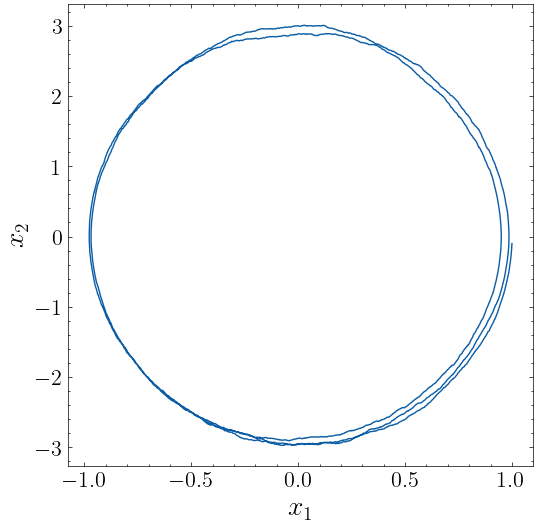

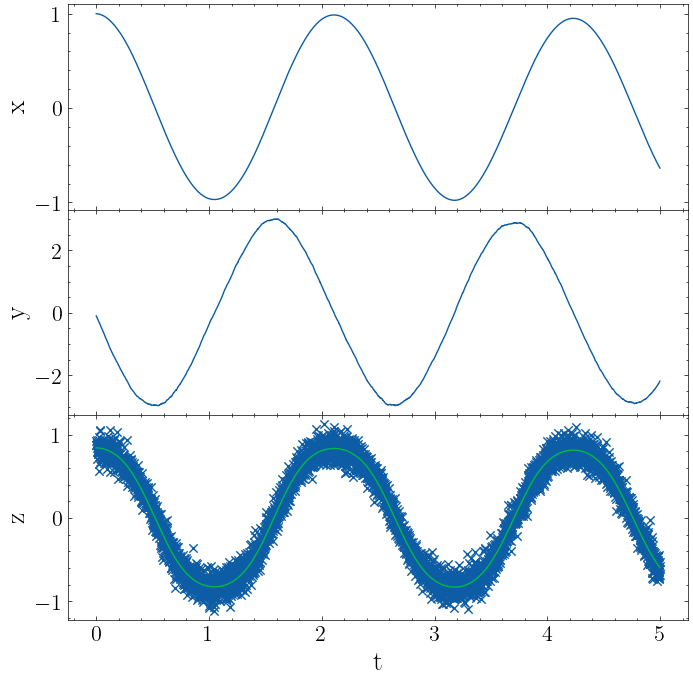

In [27]:
#Parameters of the system
g    = 10.0
σp   = 0.1
σm   = 0.1
x0   = 1.0
y0   = -0.1
seed = 1
dt   = 0.001

#Initialise the class
Pendulum = NoisyPendulum(g,σp,σm, x0, y0,seed)

#Integrate
Pendulum.integrate(dt=dt,n_steps=5000)

#Plot
Pendulum.plot_phase_space()
Pendulum.plot_timeseries(plot_true_state=True)

#### 3.3 Run the filter 

In [28]:
from model import KalmanPendulum
from kalman_filter import ExtendedKalmanFilter
from priors import constant_priors


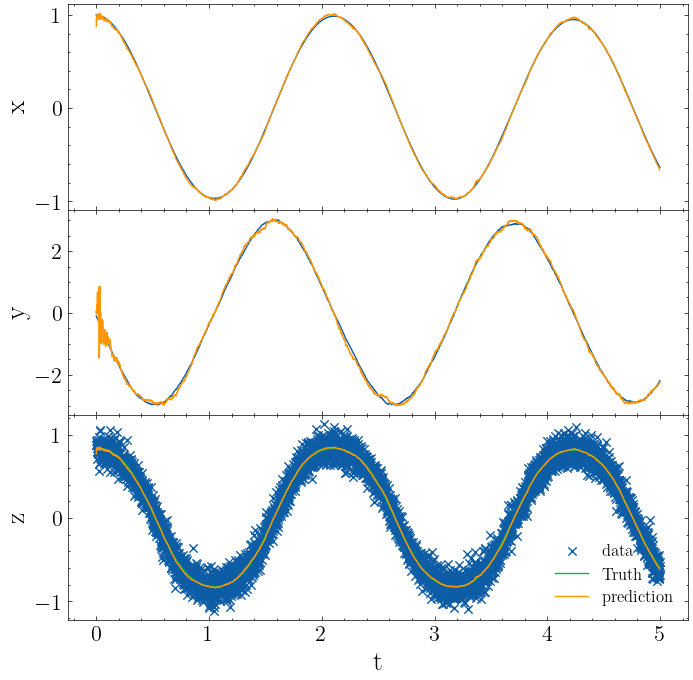

In [29]:
#Define the model
model = KalmanPendulum(dt=dt)

#Setup the filter
x_guess = np.array(([0,0]))      # guess of the initial states
P0      = 10*np.eye(2)           # uncertainty in that guess
data    = Pendulum.results[:,3].reshape(len(Pendulum.results),1)  # data to be ingested by the filter. Here reshaped to be a 2d array which the KF expects
KF      = ExtendedKalmanFilter(model,data,x_guess,P0)

# Set the system parameters
# We use bilby to set delta-priors on the parameters, 
# keeping an eye on when we will be using this in conjunction with Bayesian inference methods e.g. nested sampling
init_parameters,parameters_dict = constant_priors(g,σp,σm)

#Run the filter
KF.run(parameters_dict.sample())

#Plot the results 
Pendulum.plot_timeseries(plot_true_state=True, prediction_data=[KF.state_predictions,KF.measurement_predictions])